In [1]:
#necessary imports
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Load the CSV file
df = pd.read_csv('/kaggle/input/datasetindiansignlanguage/IndianSignLanguageDataset.csv')
df.columns = ['image_path','label']


# to take only 400 samples from each class
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

# Call the function to perform stratified sampling
stratified_df = stratified_sample_df(df, 'label', 400)  # Change 400 to your desired number of samples per class
stratified_df['image_path'] = stratified_df['image_path'].apply(lambda x: '/kaggle/input/datasetindiansignlanguage/train/'+str(x))


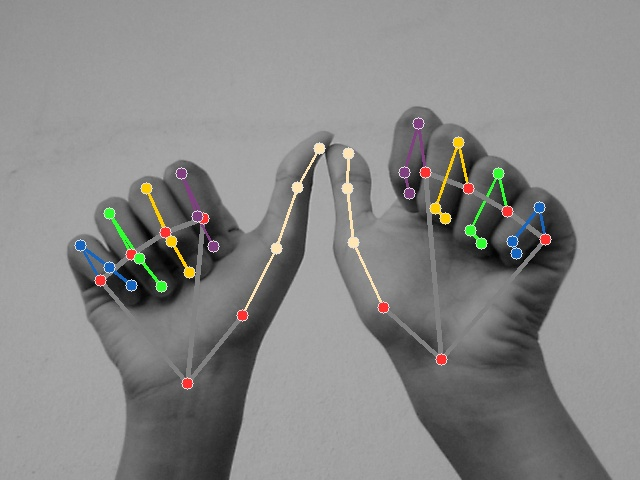

In [3]:
#The letter A
Image.open('/kaggle/input/datasetindiansignlanguage/train/Image_1679027619.2595825.jpg')

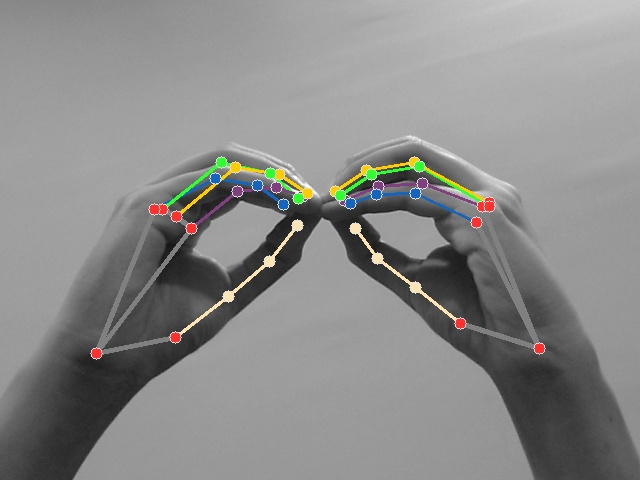

In [4]:
#The letter B
Image.open('/kaggle/input/datasetindiansignlanguage/train/Image_1679033489.2970402.jpg')

In [5]:
# Assuming that 'label' is your class column in the DataFrame
train_df, temp_df = train_test_split(stratified_df, test_size=0.3, random_state=42, stratify=stratified_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 7280
Validation set size: 1560
Test set size: 1560


In [6]:
#avialable gpus
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
# preprocessing step - rescaling the images
datagen=ImageDataGenerator(rescale=1./255.)

# train generator - loads the train set of images and labels
train_generator=datagen.flow_from_dataframe(
                dataframe=train_df,
                x_col="image_path",  # column in df that has the paths of the images
                y_col="label",  # column in df that has the image labels
                subset="training",
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="categorical",
                target_size=(32,32))

# validation generator - loads the validation set of images and labels
valid_generator=datagen.flow_from_dataframe(
                dataframe=val_df,
                x_col="image_path",  
                y_col="label", 
                batch_size=32,
                seed=42,
                shuffle=True,
                class_mode="categorical",
                target_size=(32,32))

# test generator - loads the test set of images and labels

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
                dataframe=test_df,
                x_col="image_path", 
                y_col='label', 
                batch_size=32,
                seed=42,
                shuffle=False,
                class_mode='categorical',
                target_size=(32,32))


Found 7280 validated image filenames belonging to 26 classes.
Found 1560 validated image filenames belonging to 26 classes.
Found 1560 validated image filenames belonging to 26 classes.


In [8]:
num_classes = 26

# Define and compile model 1: ResNet101
model1 = Sequential()
model1.add(ResNet101(include_top=False, pooling='avg', weights='imagenet'))
model1.add(Dense(num_classes, activation='softmax'))
model1.layers[0].trainable = False

model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define and compile model 2: EfficientNetB1
model2 = Sequential()
model2.add(DenseNet121(include_top=False, pooling='avg', weights='imagenet'))
model2.add(Dense(num_classes, activation='softmax'))
model2.layers[0].trainable = False

model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define and compile model 3: VGG16
model3 = Sequential()
model3.add(VGG16(include_top=False, pooling='avg', weights='imagenet'))
model3.add(Dense(num_classes, activation='softmax'))
model3.layers[0].trainable = False

model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy']) 



58889256/58889256 [==============================] - 0s 0us/step


In [9]:
# Define the ModelCheckpoint callback to save the best model
checkpoint1 = ModelCheckpoint('best_model1.h5', 
                             monitor='val_accuracy', 
                             mode='max', 
                             save_best_only=True)

checkpoint2 = ModelCheckpoint('best_model2.h5', 
                             monitor='val_accuracy', 
                             mode='max', 
                             save_best_only=True)

checkpoint3 = ModelCheckpoint('best_model3.h5', 
                             monitor='val_accuracy', 
                             mode='max', 
                             save_best_only=True)

In [10]:
# Train models
history1 = model1.fit(train_generator, epochs=20, validation_data=valid_generator,callbacks=[checkpoint1])
history2 = model2.fit(train_generator, epochs=20, validation_data=valid_generator,callbacks=[checkpoint2])
history3 = model3.fit(train_generator, epochs=20, validation_data=valid_generator,callbacks=[checkpoint3])

Epoch 1/20
228/228 [==============================] - 126s 497ms/step - loss: 3.2440 - accuracy: 0.0658 - val_loss: 3.1598 - val_accuracy: 0.0756
Epoch 2/20
228/228 [==============================] - 43s 187ms/step - loss: 3.1006 - accuracy: 0.1390 - val_loss: 3.0395 - val_accuracy: 0.1417
Epoch 3/20
228/228 [==============================] - 89s 389ms/step - loss: 2.9984 - accuracy: 0.1937 - val_loss: 2.9346 - val_accuracy: 0.2353
Epoch 4/20
228/228 [==============================] - 49s 214ms/step - loss: 2.8943 - accuracy: 0.2394 - val_loss: 2.8348 - val_accuracy: 0.2538
Epoch 5/20
228/228 [==============================] - 38s 166ms/step - loss: 2.8104 - accuracy: 0.2632 - val_loss: 2.7685 - val_accuracy: 0.3532
Epoch 6/20
228/228 [==============================] - 36s 159ms/step - loss: 2.7293 - accuracy: 0.2971 - val_loss: 2.6833 - val_accuracy: 0.2846
Epoch 7/20
228/228 [==============================] - 42s 182ms/step - loss: 2.6574 - accuracy: 0.3287 - val_loss: 2.6157 - val_a

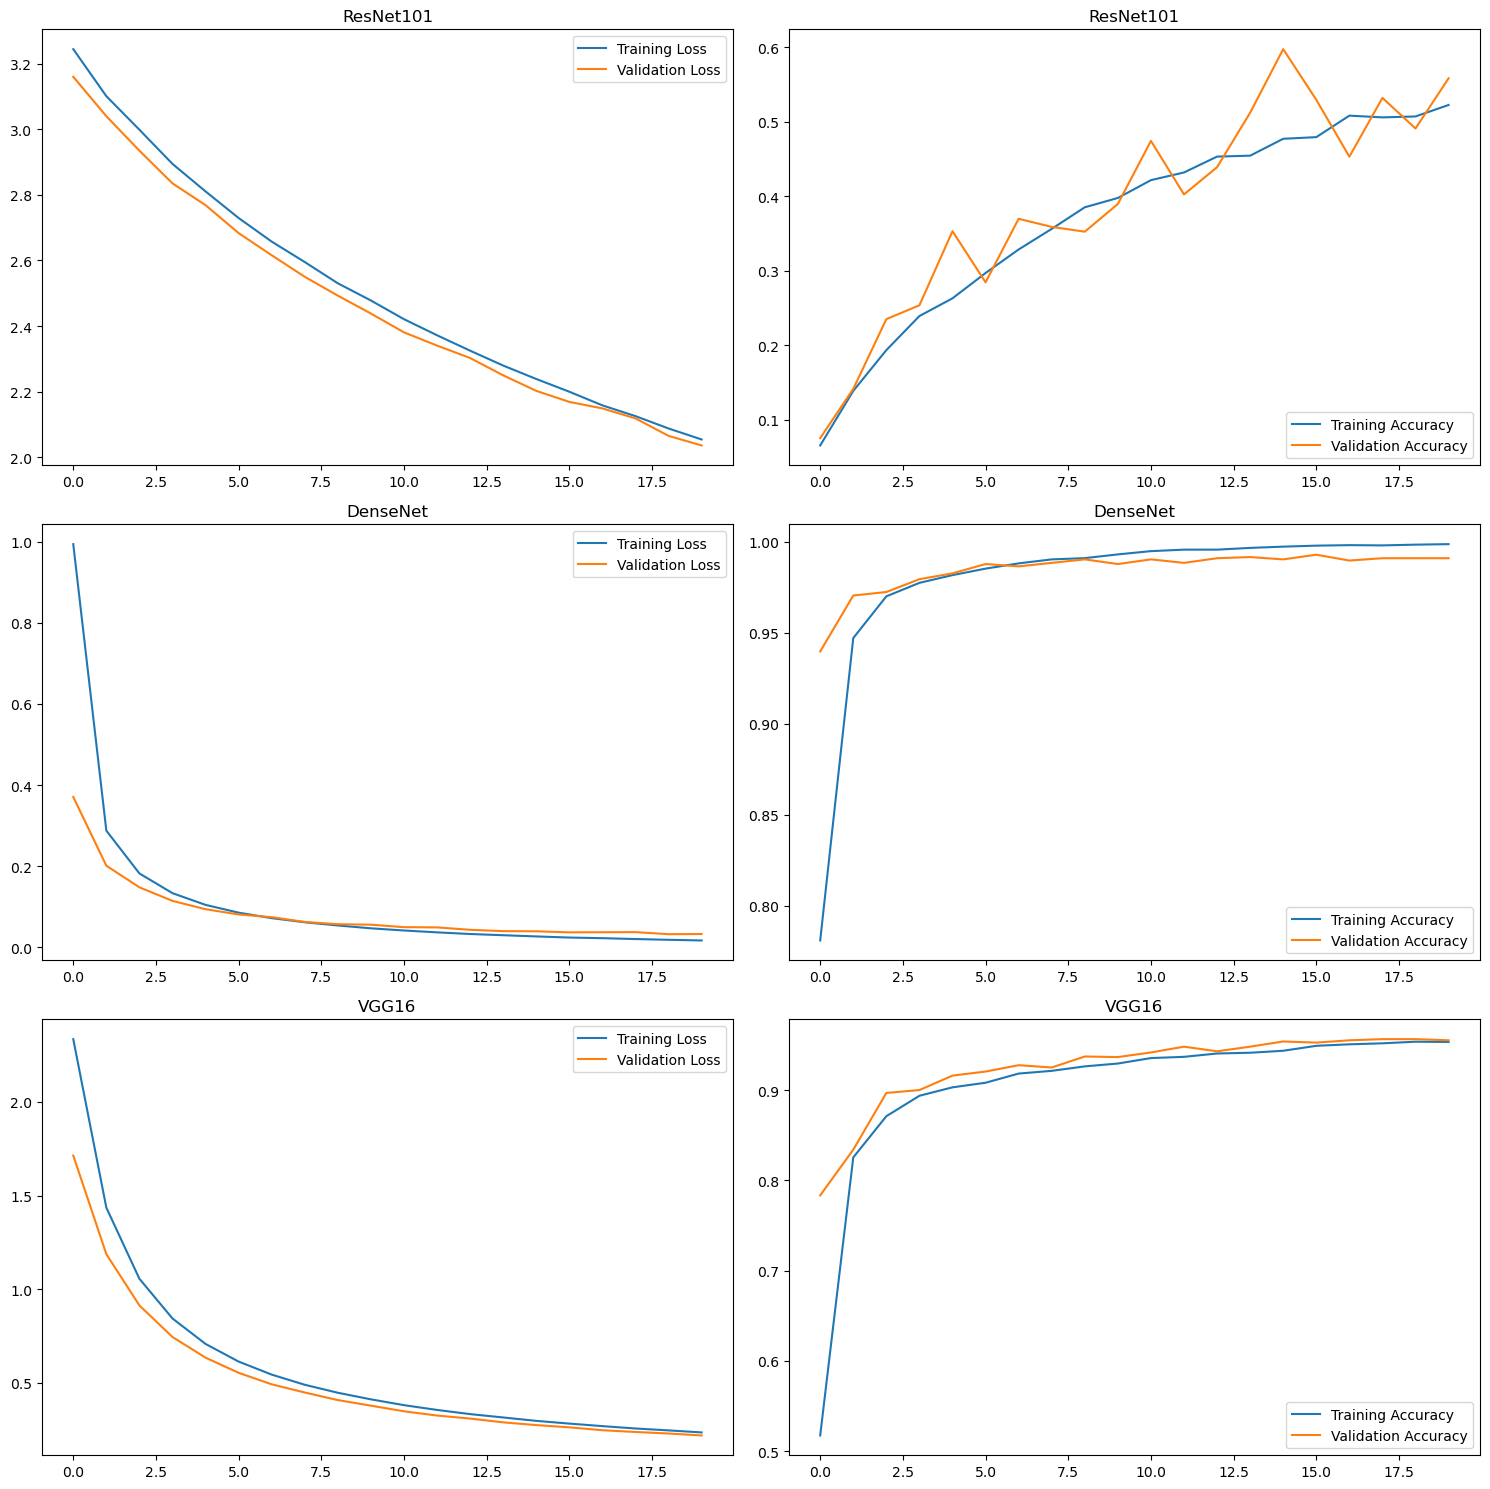

In [11]:
# Plotting training and validation loss and accuracy
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax = ax.ravel()

for i, history in enumerate([history1, history2, history3]):
    ax[2*i].plot(history.history['loss'], label='Training Loss')
    ax[2*i].plot(history.history['val_loss'], label='Validation Loss')
    ax[2*i].legend(loc='upper right')
    ax[2*i].set_title(['ResNet101', 'DenseNet', 'VGG16'][i])

    ax[2*i+1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[2*i+1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[2*i+1].legend(loc='lower right')
    ax[2*i+1].set_title(['ResNet101', 'DenseNet', 'VGG16'][i])

plt.tight_layout()
plt.show()

In [12]:
model_predictions = []
models = [model1, model2, model3]

test_labels = test_generator.labels

for i, model in enumerate(models):
    # Get the predictions
    predictions = model.predict(test_generator)

    # Convert probabilities to class labels and append to model_predictions
    predicted_classes = np.argmax(predictions, axis=1)
    model_predictions.append(predicted_classes)

    # Calculate accuracy score
    accuracy = accuracy_score(test_labels, predicted_classes)

    # Classification report
    cr = classification_report(test_labels, predicted_classes)

    print(f"Accuracy for {model}: {accuracy}")
    print('\n')
    print(f"Classification Report for {model}:\n",cr)


49/49 [==============================] - 19s 356ms/step
Accuracy for <keras.engine.sequential.Sequential object at 0x7e71fb7ded10>: 0.5384615384615384


Classification Report for <keras.engine.sequential.Sequential object at 0x7e71fb7ded10>:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76        60
           1       0.67      0.55      0.61        60
           2       0.70      0.97      0.81        60
           3       0.71      0.33      0.45        60
           4       0.85      0.97      0.91        60
           5       0.92      0.18      0.31        60
           6       0.91      0.85      0.88        60
           7       0.57      0.97      0.72        60
           8       0.75      0.35      0.48        60
           9       0.00      0.00      0.00        60
          10       0.98      0.95      0.97        60
          11       0.28      0.97      0.43        60
          12       0.69      0.92      0.79        60


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 8s 121ms/step
Accuracy for <keras.engine.sequential.Sequential object at 0x7e7149fa5750>: 0.985897435897436


Classification Report for <keras.engine.sequential.Sequential object at 0x7e7149fa5750>:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.97      0.98        60
           2       1.00      1.00      1.00        60
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        60
           5       1.00      1.00      1.00        60
           6       1.00      1.00      1.00        60
           7       0.98      1.00      0.99        60
           8       1.00      1.00      1.00        60
           9       1.00      1.00      1.00        60
          10       1.00      1.00      1.00        60
          11       1.00      1.00      1.00        60
          12       1.00      1.00      1.00        60
  

In [13]:
# Perform majority voting
ensemble_prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=model_predictions)

In [14]:
# Calculate accuracy score for final ensemble predictions
ensemble_accuracy = accuracy_score(test_labels, ensemble_prediction)

# Calculate classification report for final ensemble predictions
ensemble_cr = classification_report(test_labels, ensemble_prediction)

print(f"Accuracy for Ensemble: {ensemble_accuracy}")
print('\n')
print("Classification Report of Ensemble:\n ",ensemble_cr)

Accuracy for Ensemble: 0.9666666666666667


Classification Report of Ensemble:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      1.00      0.99        60
           2       0.95      1.00      0.98        60
           3       1.00      0.95      0.97        60
           4       1.00      1.00      1.00        60
           5       1.00      1.00      1.00        60
           6       1.00      1.00      1.00        60
           7       1.00      1.00      1.00        60
           8       1.00      1.00      1.00        60
           9       1.00      0.98      0.99        60
          10       1.00      1.00      1.00        60
          11       0.91      1.00      0.95        60
          12       1.00      1.00      1.00        60
          13       0.82      0.97      0.89        60
          14       0.80      1.00      0.89        60
          15       0.97      0.98      0.98        60
